In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

n_blocks = 4

weights = [pd.read_csv("data/my_theta/weights_set_A_t_20_rep_0.dat",sep="\s+",comment="#",names=["w0","w1"]),\
        pd.read_csv("data/my_theta/weights_set_A_t_20_rep_1.dat",sep="\s+",comment="#",names=["w0","w1"]),\
        pd.read_csv("data/my_theta/weights_set_A_t_20_rep_2.dat",sep="\s+",comment="#",names=["w0","w1"]),\
        pd.read_csv("data/my_theta/weights_set_A_t_20_rep_3.dat",sep="\s+",comment="#",names=["w0","w1"])]

# Comparison between different ensembles 
Here we compare all the experimental values with averages calculated from ensembles. 
We first define a couple of functions for reading the values and calculate averages and statistics. Later, we go through the datasets one by one.






In [34]:
def read_data(dataset,data_type):
    
    if(data_type!="gn_eNOE"):
        df_exp = pd.read_csv("data/exp/%s/%s.exp.dat" % (dataset,data_type),\
                         sep="\s+",comment="#",names=["label","val","sigma"])
    else:
        df_exp = pd.read_csv("data/exp/%s/%s.exp.dat" % (dataset,data_type),\
                         sep="\s+",comment="#",names=["label","val","sigma","bound"])
    df_2koc = pd.read_csv("data/calc/%s/2koc.%s.calc.dat" % (dataset,data_type),\
                      sep="\s+",comment="#",names=list(df_exp["label"]))
    df_6by5 = pd.read_csv("data/calc/%s/6by5.%s.calc.dat" % (dataset,data_type),\
                      sep="\s+",comment="#",names=list(df_exp["label"]))
    df_md = pd.read_csv("data/calc/%s/%s.calc.dat" % (dataset,data_type),\
                    sep="\s+",comment="#",names=list(df_exp["label"]))
    
    return df_exp, df_2koc, df_6by5, df_md


def calc_mean(df_exp,df_2koc,df_6by5,df_md,averaging=None):
    
    if(averaging=="NOE"):
        mean_2koc = np.power(np.mean(np.power(df_2koc.values,-6),axis=0),-1/6.)
        mean_6by5 = np.power(np.mean(np.power(df_6by5.values,-6),axis=0),-1/6.)
    else:
        mean_2koc = np.mean(df_2koc.values,axis=0)
        mean_6by5 = np.mean(df_6by5.values,axis=0)
        if(averaging=="SCALE"):
            scale_2koc = np.dot(df_exp["val"].values,mean_2koc)/np.dot(mean_2koc,mean_2koc)
            mean_2koc *= scale_2koc
            scale_6by5 = np.dot(df_exp["val"].values,mean_6by5)/np.dot(mean_6by5,mean_6by5)
            mean_6by5 *= scale_6by5
            print("SCALE 2KOC %.3f " % scale_2koc)
            print("SCALE 6BY5 %.3f " % scale_6by5)
        
    means_md_0 = []
    means_md_1 = []
    
    ll = df_md.shape[0]
    bsize = int(ll/n_blocks)
    for j in range(n_blocks):
        start = int(j*ll/n_blocks)
        stop = start+bsize
        #print(start,stop)
        w0_tmp = weights[j]["w0"].values
        w1_tmp = weights[j]["w1"].values
        #print(w0_tmp.shape,df_md.values[start:stop].shape)
        if(averaging=="NOE"):
            mean_tmp_0 = np.power(np.sum(w0_tmp[:,np.newaxis]*np.power(df_md.values[start:stop],-6),axis=0),-1/6)
            mean_tmp_1 = np.power(np.sum(w1_tmp[:,np.newaxis]*np.power(df_md.values[start:stop],-6),axis=0),-1/6)
        else:
            mean_tmp_0 = np.sum(df_md.values[start:stop]*w0_tmp[:,np.newaxis],axis=0)
            mean_tmp_1 = np.sum(df_md.values[start:stop]*w1_tmp[:,np.newaxis],axis=0)
            if(averaging=="SCALE"):
                scale_0 = np.dot(df_exp["val"].values,mean_tmp_0)/np.dot(mean_tmp_0,mean_tmp_0)
                mean_tmp_0 *= scale_0
                scale_1 = np.dot(df_exp["val"].values,mean_tmp_1)/np.dot(mean_tmp_1,mean_tmp_1)
                mean_tmp_1 *= scale_1
                print("SCALE MD %.3f " % scale_0)
                print("SCALE MD %.3f " % scale_1)
        means_md_0.append(mean_tmp_0)
        means_md_1.append(mean_tmp_1)
    means_md_0 = np.array(means_md_0)
    means_md_1= np.array(means_md_1)

    return mean_2koc, mean_6by5,means_md_0,means_md_1
    
    
    
def calc_stats(exp,prediction,sigma,bounds=None):
     
    diff = (exp-prediction)**2
    if(bounds=="UPPER"):
        diff1 = (exp-prediction)
        to_zero = np.where(diff1>0)
        diff[to_zero]=0.0
        
    if(bounds=="LOWER"):
        diff1 = (exp-prediction)
        to_zero = np.where(diff1<0)
        diff[to_zero]=0.0
        
    if(len(prediction.shape)==1):
        rmsd = np.sqrt(diff.mean())
        chi2 =  (diff/sigma**2).mean()
        return rmsd, chi2
    else:
        rmsds = np.sqrt(diff.mean(axis=1))
        chi2s =  (diff/sigma**2).mean(axis=1)
        
        rmsd = np.mean(rmsds)
        rmsd_sem = np.std(rmsds,ddof=1)/np.sqrt(rmsds.shape[0])
        
        chi2 = np.mean(chi2s)
        chi2_sem = np.std(chi2s,ddof=1)/np.sqrt(rmsds.shape[0])
        
        return rmsd, chi2, rmsd_sem, chi2_sem

    

pdf = PdfPages('SI2.pdf') 
all_stats = pd.DataFrame(columns=["SET","DATA_TYPE","ENSEMBLE","RMSD","RMSD_ERR","CHI2","CHI2_ERR"])

# DATASET A, eNOE

### set_A eNOE ###
RMSD: 2KOC 0.460 6BY5 0.140 MD 0.581+/-0.011 MD+EXP 0.320+/-0.021 
CHI2: 2KOC 1.000 6BY5 0.126 MD 1.905+/-0.106 MD+EXP 0.574+/-0.070


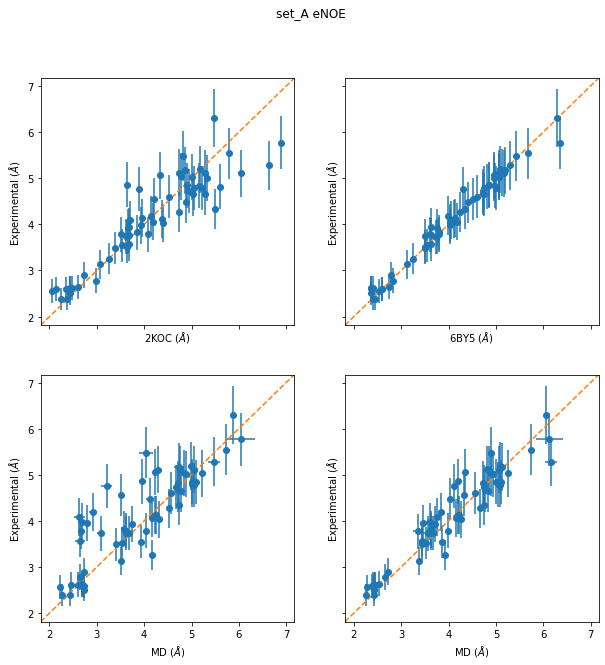

In [35]:

dataset = "set_A"
data_type= "eNOE"

# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md, averaging="NOE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)


ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC ($\AA$)")
ax[0,0].set_ylabel("Experimental ($\AA$)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 ($\AA$)")
ax[0,1].set_ylabel("Experimental ($\AA$)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD ($\AA$)")
ax[1,0].set_ylabel("Experimental ($\AA$)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD ($\AA$)")
ax[1,1].set_ylabel("Experimental ($\AA$)")


xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")


print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))
stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))


fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


# Dataset A, unidir-eNOE



### set_A eNOE_unidir ###
RMSD: 2KOC 0.444 6BY5 0.339 MD 0.471+/-0.010 MD+EXP 0.382+/-0.009 
CHI2: 2KOC 0.540 6BY5 0.302 MD 0.593+/-0.018 MD+EXP 0.418+/-0.021


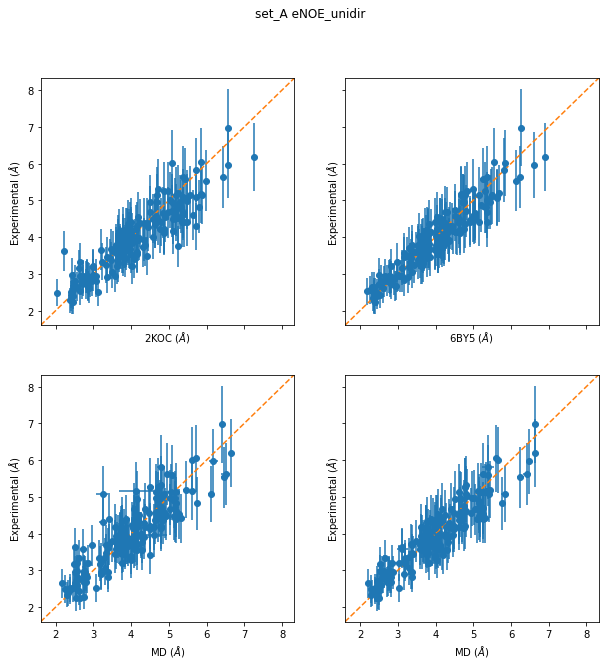

In [36]:

dataset = "set_A"
data_type= "eNOE_unidir"

# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md, averaging="NOE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC ($\AA$)")
ax[0,0].set_ylabel("Experimental ($\AA$)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 ($\AA$)")
ax[0,1].set_ylabel("Experimental ($\AA$)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD ($\AA$)")
ax[1,0].set_ylabel("Experimental ($\AA$)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD ($\AA$)")
ax[1,1].set_ylabel("Experimental ($\AA$)")

xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))
stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


# gn-eENOE,  upper/lower distance bounds

In [37]:
dataset = "set_A"
data_type= "gn_eNOE"

# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md, averaging="NOE")



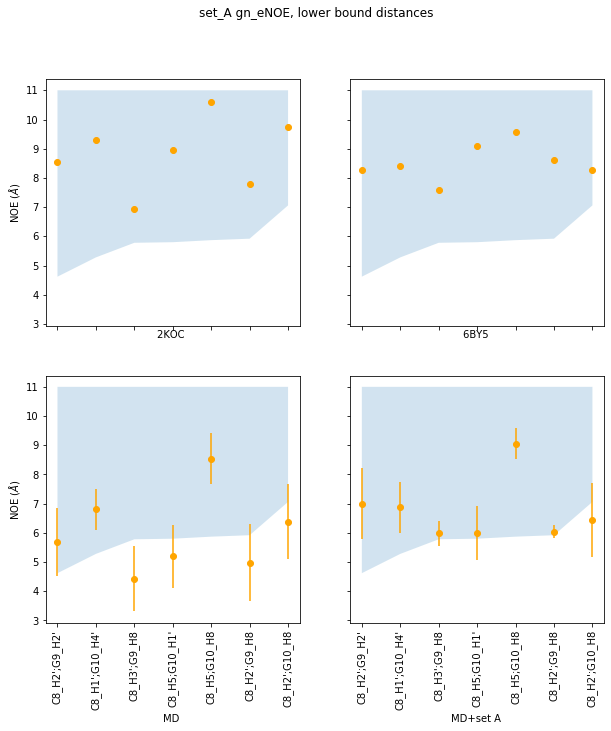

In [38]:
lower_bound_idx = np.where((df_exp["bound"]=="LOWER")==1)[0]

fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

xx = np.arange(len(lower_bound_idx))

exp_tmp = df_exp["val"].values[lower_bound_idx]
sigma_tmp = df_exp["sigma"].values[lower_bound_idx]
mean_2koc_tmp = mean_2koc[lower_bound_idx]
mean_6by5_tmp = mean_6by5[lower_bound_idx]
means_tmp_0 = means_md_0[:,lower_bound_idx]
means_tmp_1 = means_md_1[:,lower_bound_idx]
labs = df_exp["label"].values[lower_bound_idx]


ii = np.argsort(exp_tmp)
ax[0,0].set_ylabel("NOE ($\AA$)")
ax[1,0].set_ylabel("NOE ($\AA$)")

ax[0,0].fill_between(xx,11,exp_tmp[ii],alpha=0.2) 
ax[0,0].errorbar(xx,mean_2koc[ii],fmt="o",c="orange")
ax[0,0].set_xlabel("2KOC ")
ax[0,1].set_xlabel("6BY5 ")
ax[1,0].set_xlabel("MD ")
ax[1,1].set_xlabel("MD+set A ")


ax[1,1].set_xticks(xx)
ax[1,0].set_xticks(xx)

ax[1,1].set_xticklabels(labs[ii],rotation=90)
ax[1,0].set_xticklabels(labs[ii],rotation=90)

ax[0,1].fill_between(xx,11,exp_tmp[ii],alpha=0.2) 
ax[0,1].errorbar(xx,mean_6by5_tmp[ii],fmt="o",c="orange")

ax[1,0].fill_between(xx,11,exp_tmp[ii],alpha=0.2) 
ax[1,0].errorbar(xx,np.mean(means_tmp_0[:,ii],axis=0),fmt="o",yerr=np.std(means_tmp_0[:,ii],axis=0,ddof=1),c="orange")


ax[1,1].fill_between(xx,11,exp_tmp[ii],alpha=0.2) 
ax[1,1].errorbar(xx,np.mean(means_tmp_1[:,ii],axis=0),fmt="o",yerr=np.std(means_tmp_1[:,ii],axis=0,ddof=1),c="orange")


fig.suptitle("%s %s, lower bound distances" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()


In [39]:
print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(exp_tmp,mean_2koc_tmp,sigma_tmp,"LOWER"))
stats_6by5 = (calc_stats(exp_tmp,mean_6by5_tmp,sigma_tmp,"LOWER"))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values,"LOWER"))
stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values,"LOWER"))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

all_stats.loc[len(all_stats)] = [dataset,data_type + " lower","2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type + " lower","6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type + " lower","MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type + " lower","MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]

### set_A gn_eNOE ###
RMSD: 2KOC 0.000 6BY5 0.000 MD 0.604+/-0.027 MD+EXP 0.546+/-0.009 
CHI2: 2KOC 0.000 6BY5 0.000 MD 1.792+/-0.076 MD+EXP 1.587+/-0.021


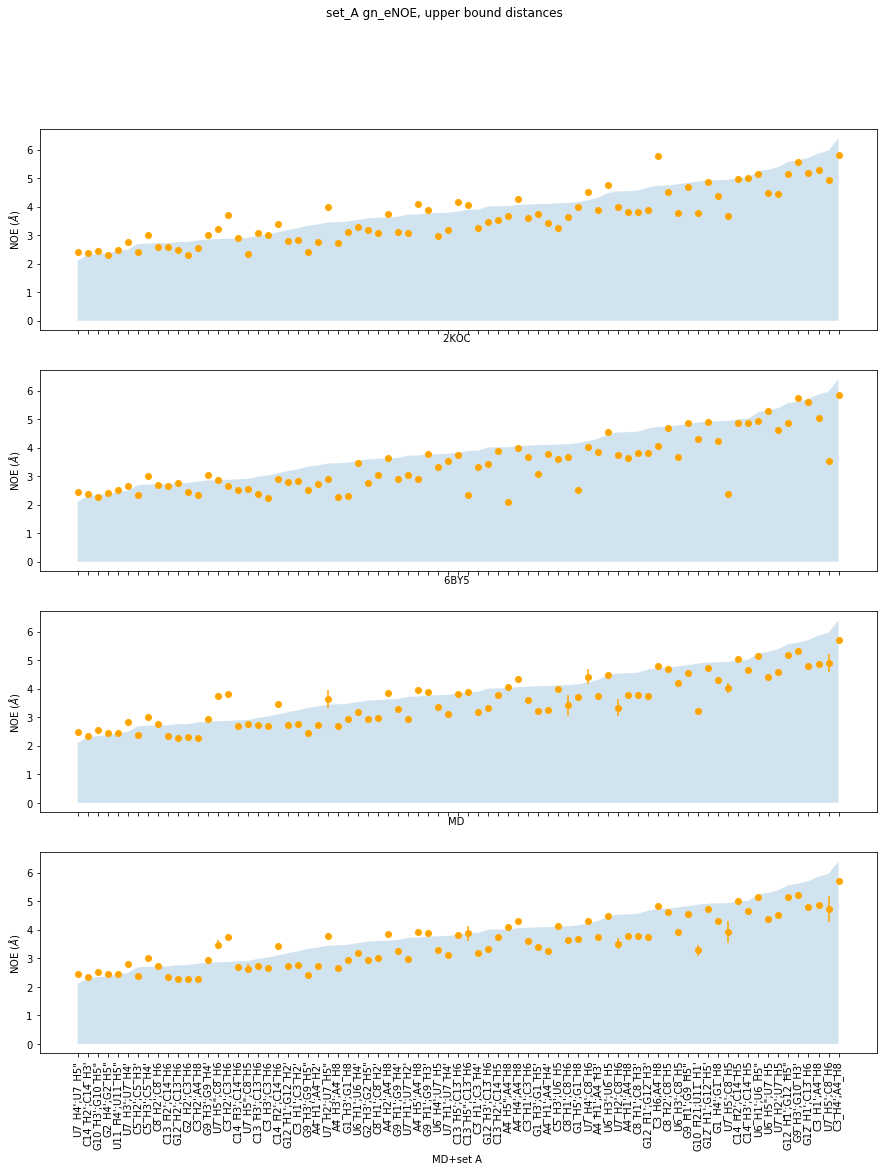

In [40]:
upper_bound_idx = np.where((df_exp["bound"]=="UPPER")==1)[0]

fig, ax = plt.subplots(4,1,figsize=(15,17),sharex=True,sharey=True)

xx = np.arange(len(upper_bound_idx))

exp_tmp = df_exp["val"].values[upper_bound_idx]
sigma_tmp = df_exp["sigma"].values[upper_bound_idx]
mean_2koc_tmp = mean_2koc[upper_bound_idx]
mean_6by5_tmp = mean_6by5[upper_bound_idx]
means_tmp_0 = means_md_0[:,upper_bound_idx]
means_tmp_1 = means_md_1[:,upper_bound_idx]
labs = df_exp["label"].values[upper_bound_idx]

ii = np.argsort(exp_tmp)
ax[0].fill_between(xx,exp_tmp[ii],alpha=0.2) 
ax[0].errorbar(xx,mean_2koc_tmp[ii],fmt="o",c="orange")

ax[3].set_xticks(xx)
ax[3].set_xticks(xx)

ax[3].set_xticklabels(labs[ii],rotation=90)
ax[3].set_xticklabels(labs[ii],rotation=90)

ax[1].fill_between(xx,exp_tmp[ii],alpha=0.2) 
ax[1].errorbar(xx,mean_6by5_tmp[ii],fmt="o",c="orange")

ax[2].fill_between(xx,exp_tmp[ii],alpha=0.2) 
ax[2].errorbar(xx,np.mean(means_tmp_0[:,ii],axis=0),fmt="o",yerr=np.std(means_tmp_0[:,ii],axis=0,ddof=1),c="orange")

ax[3].fill_between(xx,exp_tmp[ii],alpha=0.2) 
ax[3].errorbar(xx,np.mean(means_tmp_1[:,ii],axis=0),fmt="o",yerr=np.std(means_tmp_1[:,ii],axis=0,ddof=1),c="orange")

ax[0].set_xlabel("2KOC ")
ax[1].set_xlabel("6BY5 ")
ax[2].set_xlabel("MD ")
ax[3].set_xlabel("MD+set A ")

ax[0].set_ylabel("NOE ($\AA$)")
ax[1].set_ylabel("NOE ($\AA$)")
ax[2].set_ylabel("NOE ($\AA$)")
ax[3].set_ylabel("NOE ($\AA$)")

fig.suptitle("%s %s, upper bound distances" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()


In [41]:
print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(exp_tmp,mean_2koc_tmp,sigma_tmp,"UPPER"))
stats_6by5 = (calc_stats(exp_tmp,mean_6by5_tmp,sigma_tmp,"UPPER"))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values,"UPPER"))
stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values,"UPPER"))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

all_stats.loc[len(all_stats)] = [dataset,data_type + " upper","2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type + " upper","6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type + " upper","MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type + " upper","MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


### set_A gn_eNOE ###
RMSD: 2KOC 0.200 6BY5 0.063 MD 0.421+/-0.044 MD+EXP 0.521+/-0.041 
CHI2: 2KOC 0.349 6BY5 0.067 MD 0.890+/-0.129 MD+EXP 1.195+/-0.163


# DATASET B, NOE

### set_B NOE ###
RMSD: 2KOC 0.740 6BY5 0.756 MD 0.680+/-0.009 MD+EXP 0.728+/-0.003 
CHI2: 2KOC 0.493 6BY5 0.629 MD 0.430+/-0.014 MD+EXP 0.543+/-0.006


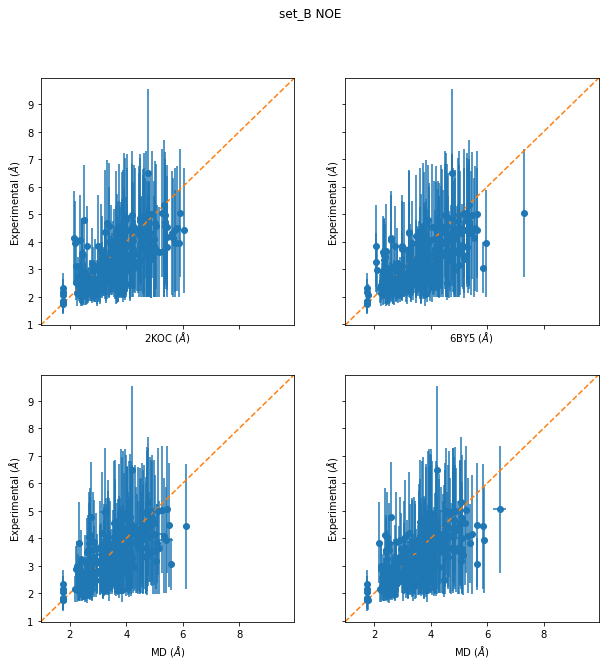

In [42]:
dataset = "set_B"
data_type= "NOE"

# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md, averaging="NOE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC ($\AA$)")
ax[0,0].set_ylabel("Experimental ($\AA$)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 ($\AA$)")
ax[0,1].set_ylabel("Experimental ($\AA$)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD ($\AA$)")
ax[1,0].set_ylabel("Experimental ($\AA$)")


ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD ($\AA$)")
ax[1,1].set_ylabel("Experimental ($\AA$)")

xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))
stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]



# DATASET B, RDC


SCALE 2KOC 0.628 
SCALE 6BY5 0.613 
SCALE MD 0.735 
SCALE MD 0.705 
SCALE MD 0.691 
SCALE MD 0.728 
SCALE MD 0.707 
SCALE MD 0.689 
SCALE MD 0.655 
SCALE MD 0.692 
### set_B RDC ###
RMSD: 2KOC 3.758 6BY5 4.468 MD 4.170+/-0.059 MD+EXP 4.030+/-0.113 
CHI2: 2KOC 14.124 6BY5 19.959 MD 17.400+/-0.488 MD+EXP 16.277+/-0.931


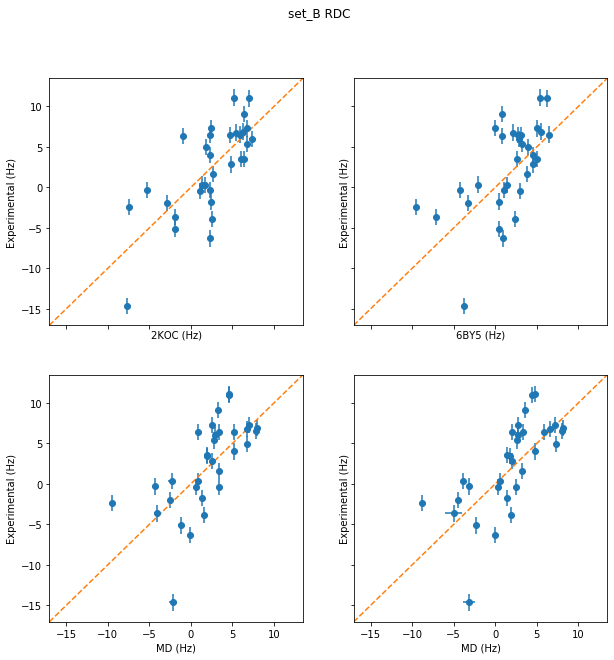

In [43]:
dataset = "set_B"
data_type= "RDC"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md, averaging="SCALE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (Hz)")
ax[0,0].set_ylabel("Experimental (Hz)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (Hz)")
ax[0,1].set_ylabel("Experimental (Hz)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (Hz)")
ax[1,0].set_ylabel("Experimental (Hz)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (Hz)")
ax[1,1].set_ylabel("Experimental (Hz)")

xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]



# DATASET B, J3

### set_B J3 ###
RMSD: 2KOC 2.309 6BY5 2.779 MD 2.464+/-0.025 MD+EXP 2.599+/-0.049 
CHI2: 2KOC 2.371 6BY5 3.432 MD 2.699+/-0.055 MD+EXP 3.005+/-0.114


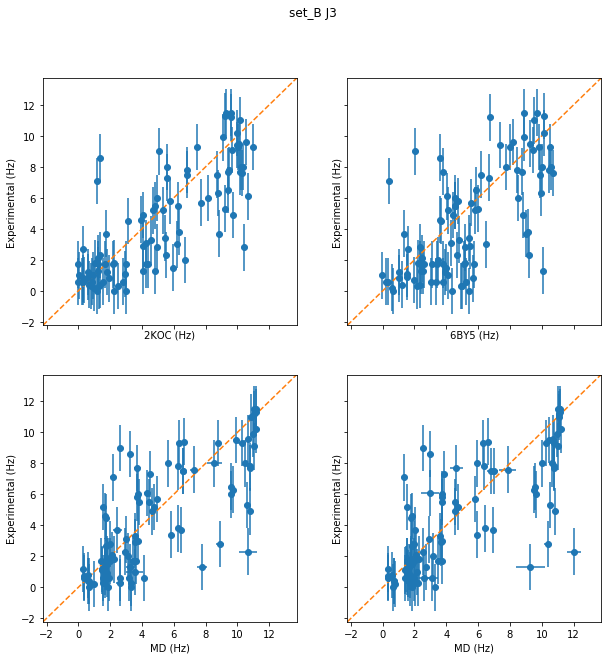

In [44]:
dataset = "set_B"
data_type= "J3"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md)

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (Hz)")
ax[0,0].set_ylabel("Experimental (Hz)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (Hz)")
ax[0,1].set_ylabel("Experimental (Hz)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (Hz)")
ax[1,0].set_ylabel("Experimental (Hz)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (Hz)")
ax[1,1].set_ylabel("Experimental (Hz)")


xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


In [45]:
df_exp["2koc"]=mean_2koc
df_exp["6by5"]=mean_6by5
df_exp["MD"] = np.mean(means_md_0,axis=0)
df_exp["MD_SEM"] = np.std(means_md_0,axis=0,ddof=1)/2.

df_exp["MDEXP"] = np.mean(means_md_1,axis=0)
df_exp["MDEXP_SEM"] = np.std(means_md_1,axis=0,ddof=1)/2.


df_exp["tipo"] = df_exp.apply(lambda x: x["label"].split("-")[1],axis=1)
df_exp["residue"] = df_exp.apply(lambda x: x["label"].split("-")[0],axis=1)

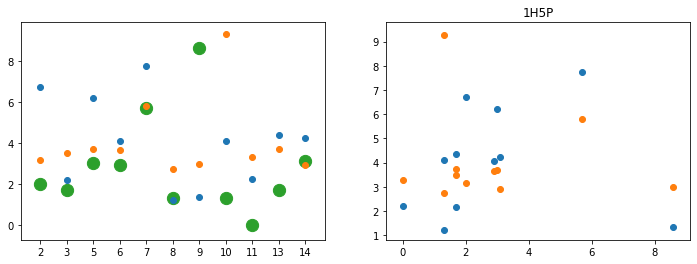

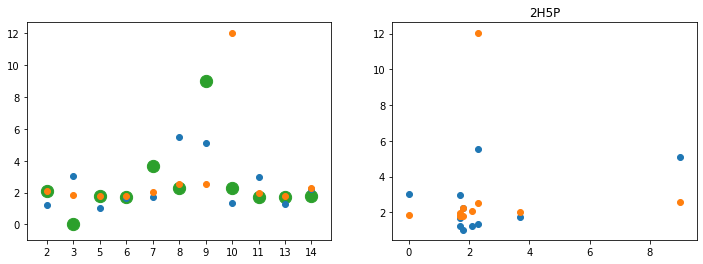

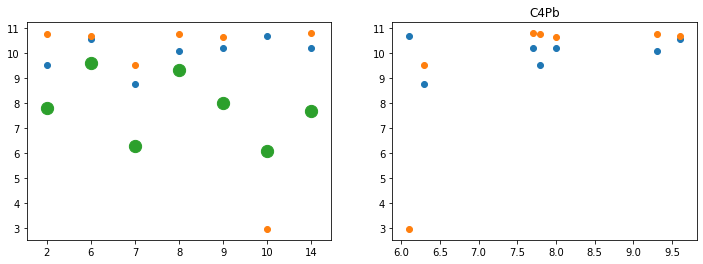

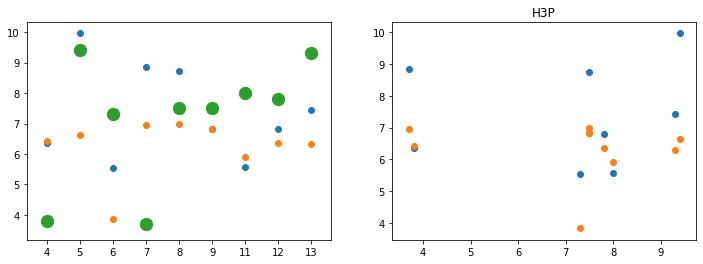

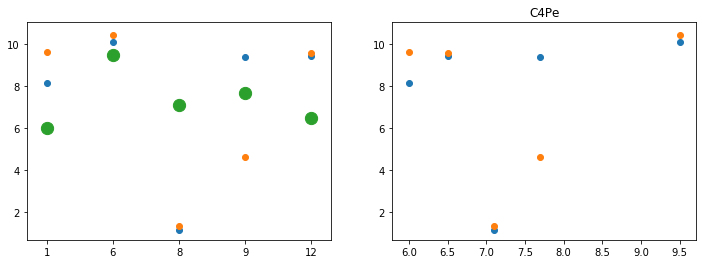

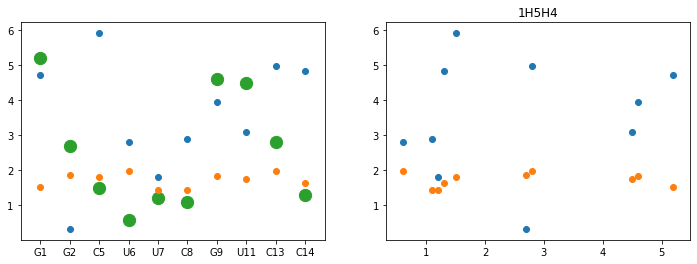

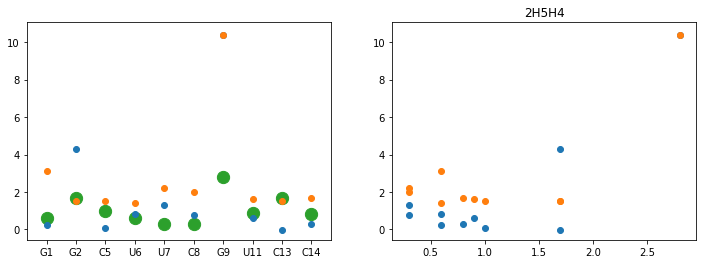

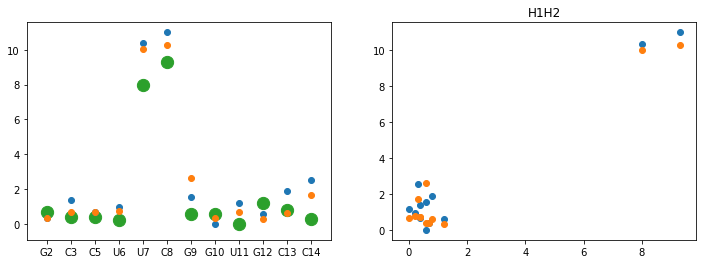

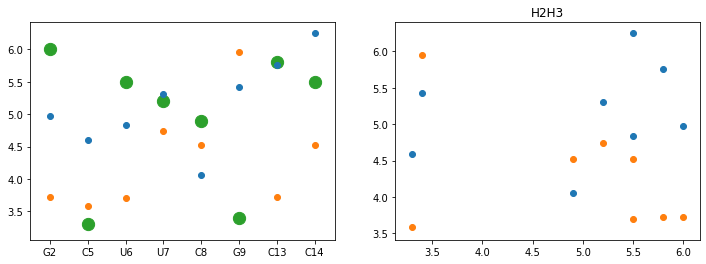

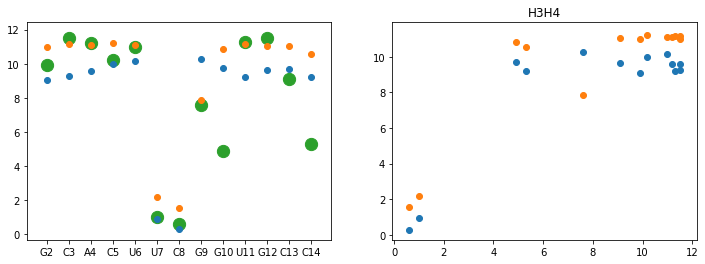

In [46]:
group_type = df_exp.groupby(["tipo"])
types = df_exp.tipo.unique()
for j in range(len(types)):
    fig, ax = plt.subplots(1,2,figsize=(12,4))

    plt.title(types[j])
    xx = np.arange(len(group_type.get_group(types[j])))

    ax[0].scatter(xx,group_type.get_group(types[j])["2koc"])

    ax[0].scatter(xx,group_type.get_group(types[j])["MDEXP"])
    ax[0].scatter(xx,group_type.get_group(types[j])["val"],s=150,zorder=-1)
    
    labs = list(group_type.get_group(types[j])["residue"])
    ax[0].set_xticks(xx)
    ax[0].set_xticklabels(labs)

    ax[1].scatter(group_type.get_group(types[j])["val"],group_type.get_group(types[j])["2koc"])
    ax[1].scatter(group_type.get_group(types[j])["val"],group_type.get_group(types[j])["MDEXP"])
    plt.show()
    plt.close()


# DATASET B, CCRR


SCALE 2KOC 0.815 
SCALE 6BY5 0.962 
SCALE MD 0.859 
SCALE MD 0.832 
SCALE MD 0.847 
SCALE MD 0.819 
SCALE MD 0.847 
SCALE MD 0.840 
SCALE MD 0.841 
SCALE MD 0.830 
### set_B CCRR ###
RMSD: 2KOC 4.736 6BY5 4.282 MD 4.356+/-0.094 MD+EXP 4.058+/-0.113 
CHI2: 2KOC 5.607 6BY5 4.583 MD 4.751+/-0.202 MD+EXP 4.127+/-0.228


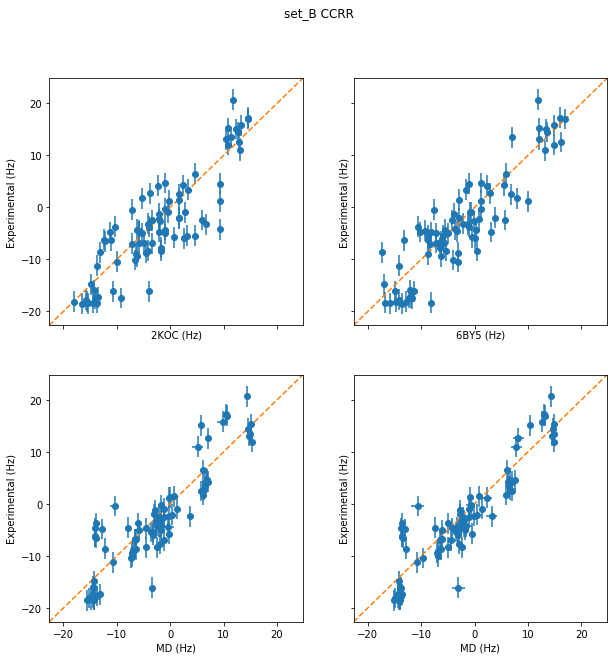

In [47]:
dataset = "set_B"
data_type= "CCRR"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md,"SCALE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (Hz)")
ax[0,0].set_ylabel("Experimental (Hz)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (Hz)")
ax[0,1].set_ylabel("Experimental (Hz)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (Hz)")
ax[1,0].set_ylabel("Experimental (Hz)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (Hz)")
ax[1,1].set_ylabel("Experimental (Hz)")


xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


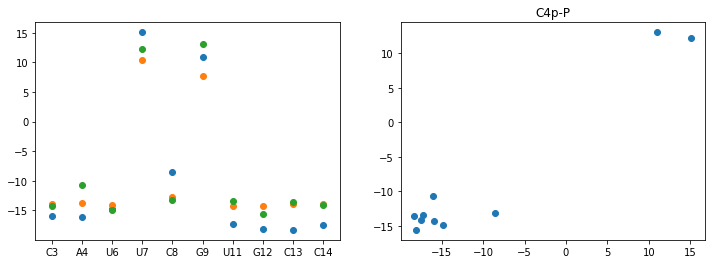

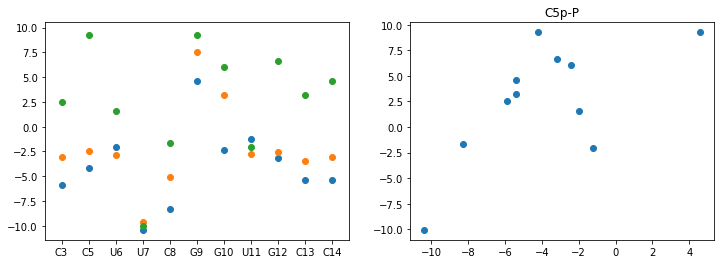

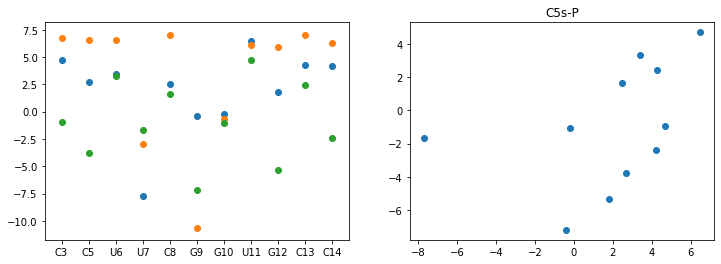

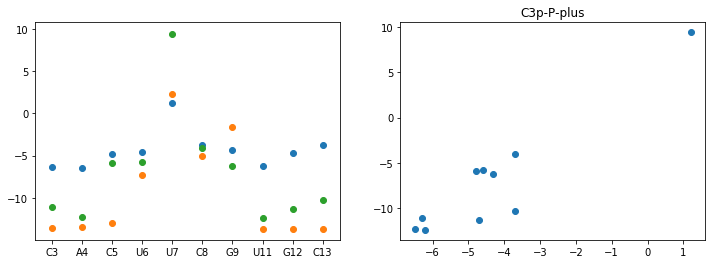

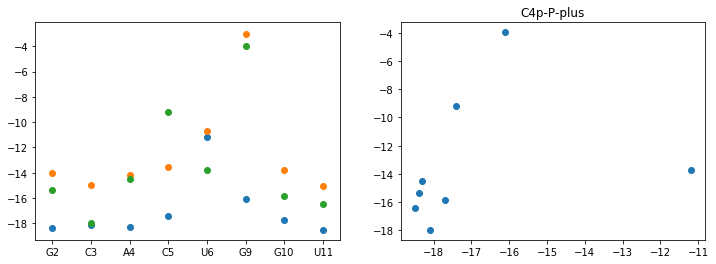

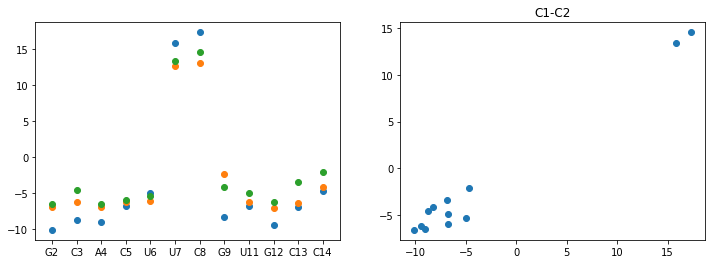

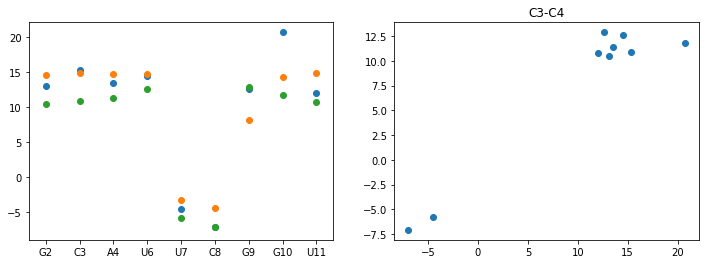

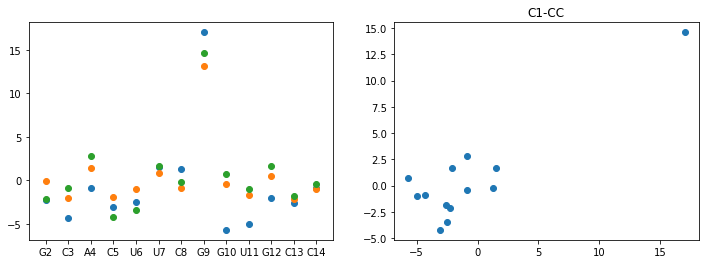

In [48]:
df_exp["2koc"]=mean_2koc
df_exp["6by5"]=mean_6by5
df_exp["MD"] = np.mean(means_md_0,axis=0)
df_exp["MD_SEM"] = np.std(means_md_0,axis=0,ddof=1)/2.

df_exp["MDEXP"] = np.mean(means_md_1,axis=0)
df_exp["MDEXP_SEM"] = np.std(means_md_1,axis=0,ddof=1)/2.

df_exp["tipo"] = df_exp.apply(lambda x: x["label"].split(":")[1],axis=1)
df_exp["residue"] = df_exp.apply(lambda x: x["label"].split(":")[0],axis=1)

group_type = df_exp.groupby(["tipo"])
types = df_exp.tipo.unique()
for j in range(len(types)):
    fig, ax = plt.subplots(1,2,figsize=(12,4))

    plt.title(types[j])
    xx = np.arange(len(group_type.get_group(types[j])))

    ax[0].scatter(xx,group_type.get_group(types[j])["val"])
    ax[0].scatter(xx,group_type.get_group(types[j])["MDEXP"])
    ax[0].scatter(xx,group_type.get_group(types[j])["2koc"])
    labs = list(group_type.get_group(types[j])["residue"])
    ax[0].set_xticks(xx)
    ax[0].set_xticklabels(labs)

    ax[1].scatter(group_type.get_group(types[j])["val"],group_type.get_group(types[j])["2koc"])
    plt.show()
    plt.close()


# DATASET C, RDC1


SCALE 2KOC 1.085 
SCALE 6BY5 1.021 
SCALE MD 1.114 
SCALE MD 1.023 
SCALE MD 1.004 
SCALE MD 1.038 
SCALE MD 1.064 
SCALE MD 1.010 
SCALE MD 1.014 
SCALE MD 1.016 
### set_C RDC1 ###
RMSD: 2KOC 6.104 6BY5 8.109 MD 8.266+/-0.096 MD+EXP 8.116+/-0.177 
CHI2: 2KOC 19.009 6BY5 33.549 MD 34.877+/-0.802 MD+EXP 33.656+/-1.493


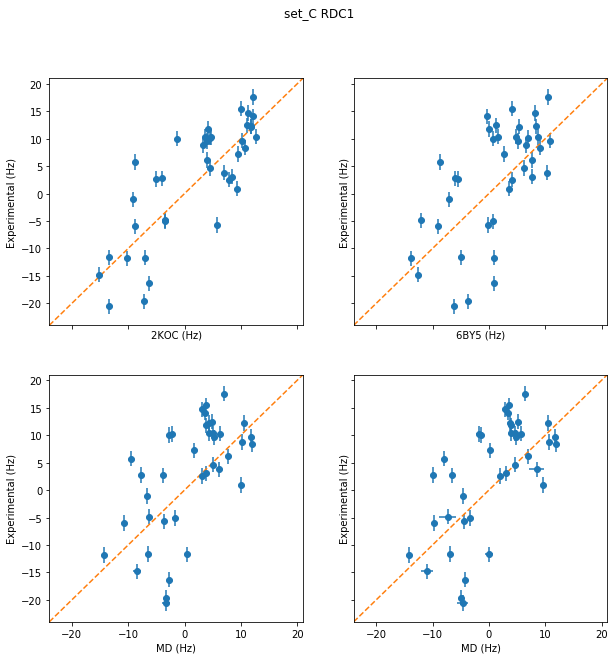

In [49]:
dataset = "set_C"
data_type= "RDC1"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md,"SCALE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (Hz)")
ax[0,0].set_ylabel("Experimental (Hz)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (Hz)")
ax[0,1].set_ylabel("Experimental (Hz)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (Hz)")
ax[1,0].set_ylabel("Experimental (Hz)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (Hz)")
ax[1,1].set_ylabel("Experimental (Hz)")


xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


SCALE 2KOC 0.601 
SCALE 6BY5 0.452 
SCALE MD 0.619 
SCALE MD 0.591 
SCALE MD 0.617 
SCALE MD 0.593 
SCALE MD 0.661 
SCALE MD 0.595 
SCALE MD 0.572 
SCALE MD 0.561 
### set_C RDC2 ###
RMSD: 2KOC 6.653 6BY5 7.473 MD 7.252+/-0.035 MD+EXP 7.222+/-0.033 
CHI2: 2KOC 9.145 6BY5 11.537 MD 10.866+/-0.105 MD+EXP 10.777+/-0.098


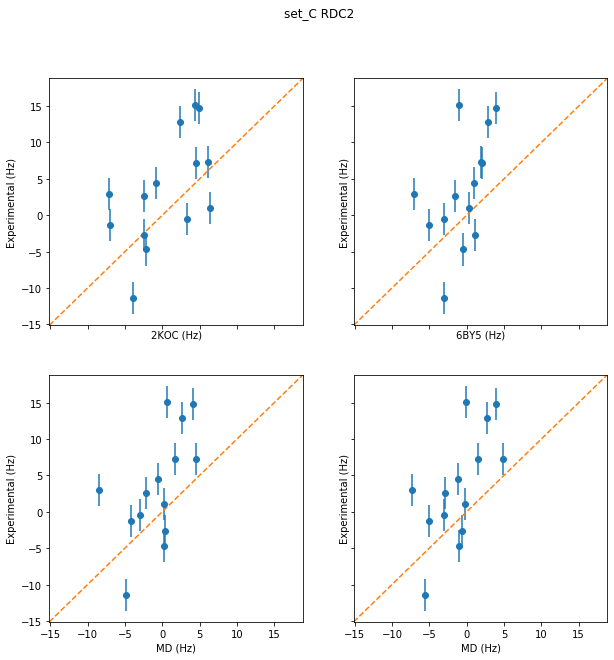

In [50]:
dataset = "set_C"
data_type= "RDC2"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md,"SCALE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (Hz)")
ax[0,0].set_ylabel("Experimental (Hz)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (Hz)")
ax[0,1].set_ylabel("Experimental (Hz)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (Hz)")
ax[1,0].set_ylabel("Experimental (Hz)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (Hz)")
ax[1,1].set_ylabel("Experimental (Hz)")

xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


# DATASET D, sPRE

SCALE 2KOC 0.006 
SCALE 6BY5 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
SCALE MD 0.006 
### set_D sPRE ###
RMSD: 2KOC 0.317 6BY5 0.319 MD 0.304+/-0.001 MD+EXP 0.305+/-0.001 
CHI2: 2KOC 189.803 6BY5 157.967 MD 175.452+/-1.628 MD+EXP 191.837+/-1.525


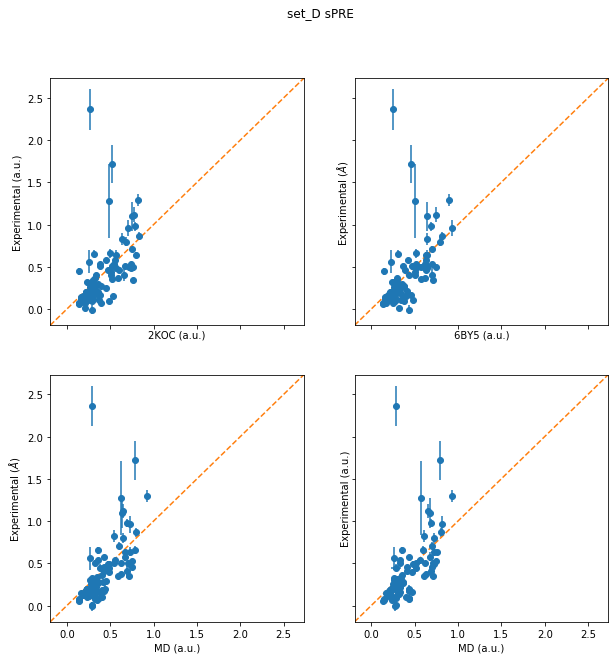

In [51]:
dataset = "set_D"
data_type= "sPRE"
# read data
df_exp, df_2koc, df_6by5, df_md = read_data(dataset,data_type)

# calculate averages
mean_2koc, mean_6by5,means_md_0,means_md_1 = calc_mean(df_exp, df_2koc, df_6by5, df_md,"SCALE")

# plot 
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

ax[0,0].errorbar(mean_2koc,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,0].set_xlabel("2KOC (a.u.)")
ax[0,0].set_ylabel("Experimental (a.u.)")

ax[0,1].errorbar(mean_6by5,df_exp["val"],yerr=df_exp["sigma"],fmt="o")
ax[0,1].set_xlabel("6BY5 (a.u.)")
ax[0,1].set_ylabel("Experimental ($\AA$)")

ax[1,0].errorbar(np.mean(means_md_0,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_0,axis=0)/2)
ax[1,0].set_xlabel("MD (a.u.)")
ax[1,0].set_ylabel("Experimental ($\AA$)")

ax[1,1].errorbar(np.mean(means_md_1,axis=0),df_exp["val"],\
                 yerr=df_exp["sigma"],fmt="o",xerr=np.std(means_md_1,axis=0)/2)
ax[1,1].set_xlabel("MD (a.u.)")
ax[1,1].set_ylabel("Experimental (a.u.)")

xlim_0 = ax[0,0].get_xlim()
ylim_0 = ax[0,0].get_ylim()
lower_b = np.min([xlim_0[0],ylim_0[0]])
upper_b = np.max([xlim_0[1],ylim_0[1]])
ax[0,0].set_ylim(lower_b,upper_b)
ax[0,0].set_xlim(lower_b,upper_b)
ax[0,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[0,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,0].plot([lower_b,upper_b],[lower_b,upper_b],"--")
ax[1,1].plot([lower_b,upper_b],[lower_b,upper_b],"--")

print("### %s %s ###"  % (dataset, data_type))
stats_2koc = (calc_stats(df_exp["val"].values,mean_2koc,df_exp["sigma"].values))
stats_6by5 = (calc_stats(df_exp["val"].values,mean_6by5,df_exp["sigma"].values))
stats_md_0 = (calc_stats(df_exp["val"].values,means_md_0,df_exp["sigma"].values))

stats_md_1 = (calc_stats(df_exp["val"].values,means_md_1,df_exp["sigma"].values))

print("RMSD: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f "\
      % (stats_2koc[0],stats_6by5[0],stats_md_0[0],stats_md_0[2],stats_md_1[0],stats_md_1[2]))
print("CHI2: 2KOC %.3f 6BY5 %.3f MD %.3f+/-%.3f MD+EXP %.3f+/-%.3f"\
      % (stats_2koc[1],stats_6by5[1],stats_md_0[1],stats_md_0[3],stats_md_1[1],stats_md_1[3]))

fig.suptitle("%s %s" % (dataset,data_type))
pdf.savefig()
plt.show()
plt.close()
all_stats.loc[len(all_stats)] = [dataset,data_type,"2KOC",stats_2koc[0],0.0,stats_2koc[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"6BY5",stats_6by5[0],0.0,stats_6by5[1],0.0]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD",stats_md_0[0],stats_md_0[2],stats_md_0[1],stats_md_0[3]]
all_stats.loc[len(all_stats)] = [dataset,data_type,"MD+setA",stats_md_1[0],stats_md_1[2],stats_md_1[1],stats_md_1[3]]


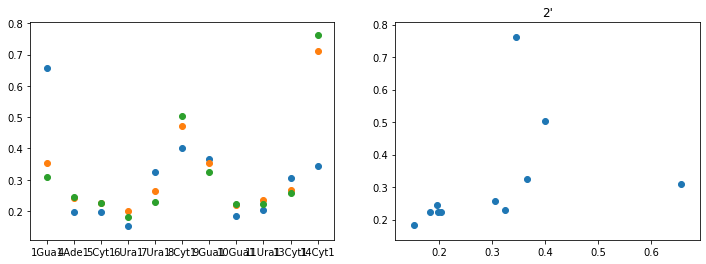

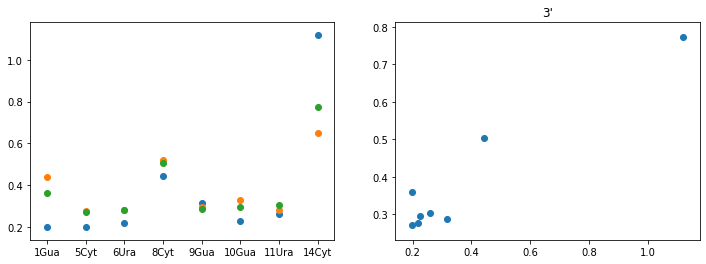

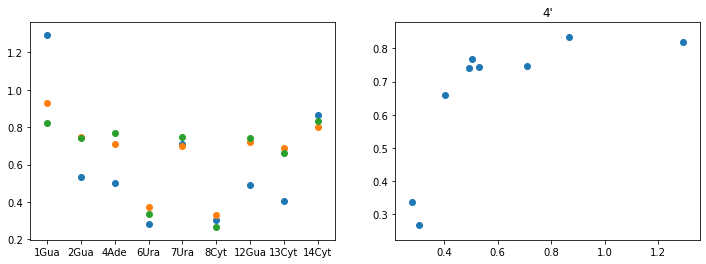

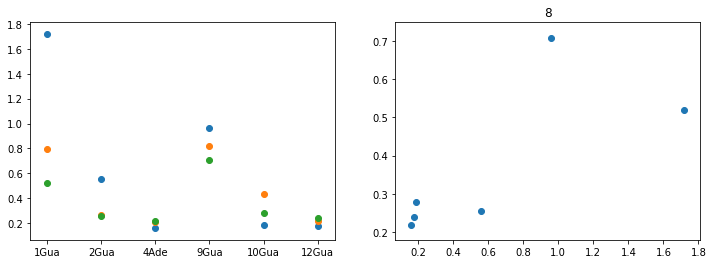

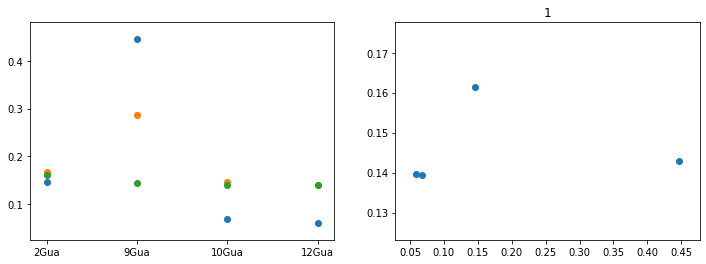

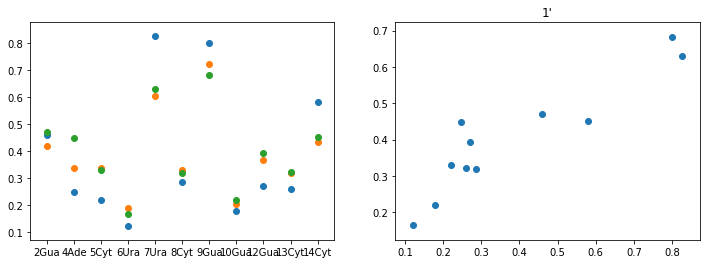

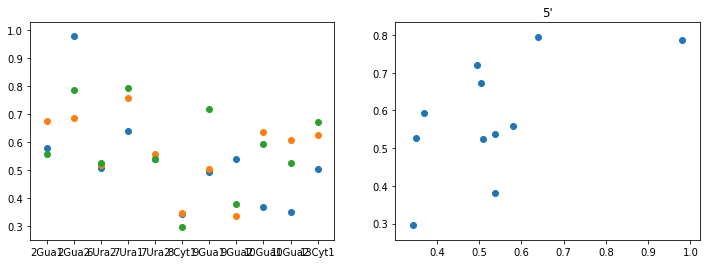

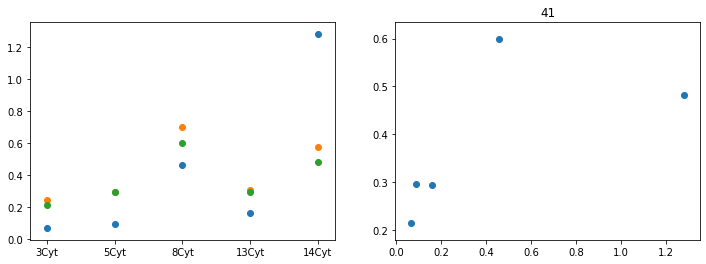

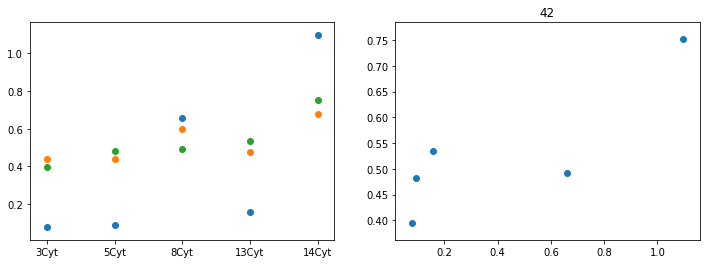

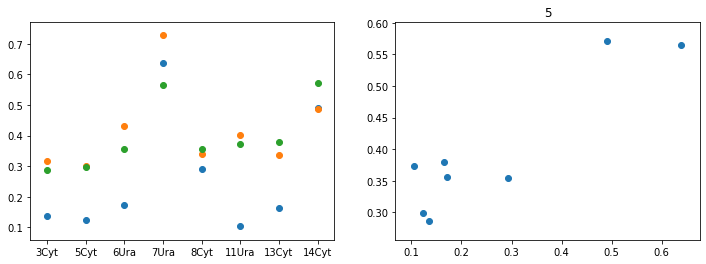

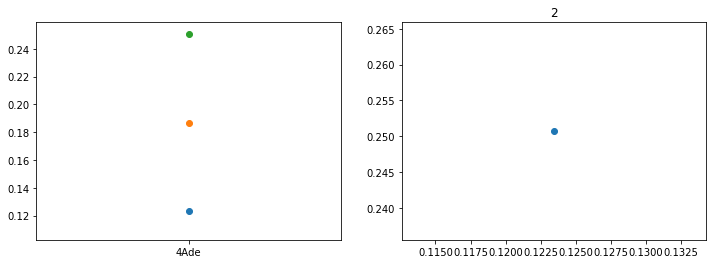

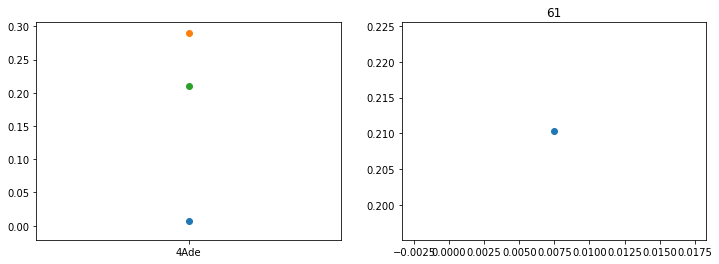

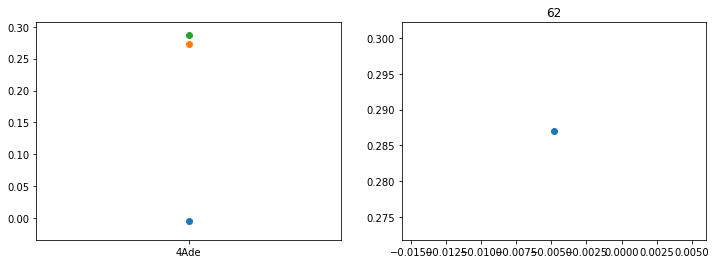

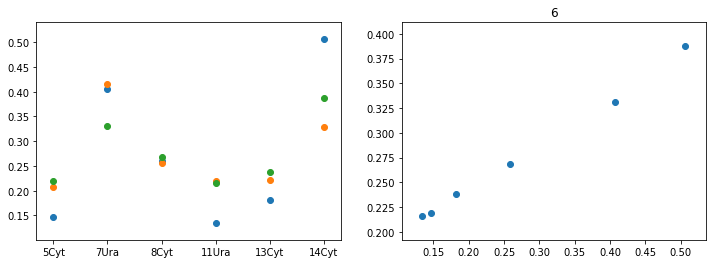

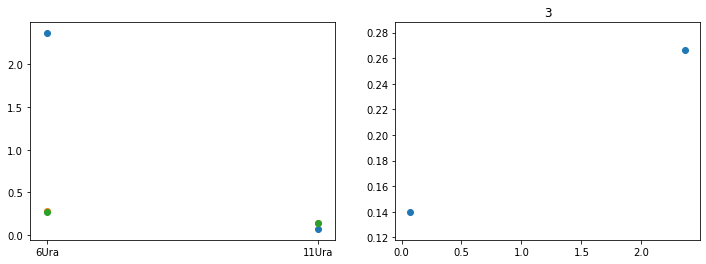

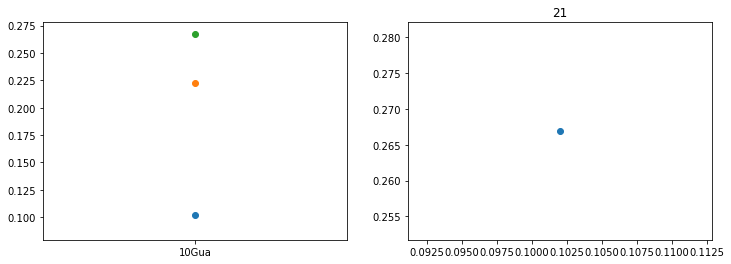

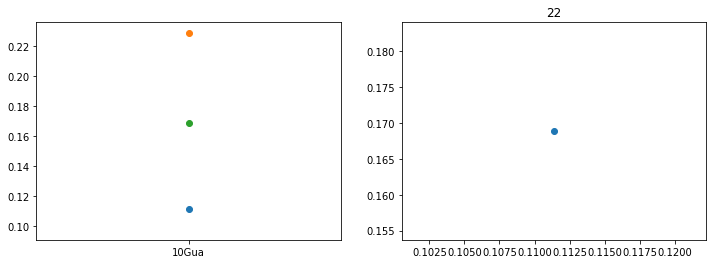

In [52]:
df_exp["2koc"]=mean_2koc
df_exp["6by5"]=mean_6by5
df_exp["MD"] = np.mean(means_md_0,axis=0)
df_exp["MD_SEM"] = np.std(means_md_0,axis=0,ddof=1)/2.
df_exp["MDEXP"] = np.mean(means_md_1,axis=0)
df_exp["MDEXP_SEM"] = np.std(means_md_1,axis=0,ddof=1)/2.

df_exp["tipo"] = df_exp.apply(lambda x: x["label"].split("H")[1],axis=1)
df_exp["residue"] = df_exp.apply(lambda x: x["label"].split("H")[0],axis=1)

group_type = df_exp.groupby(["tipo"])
types = df_exp.tipo.unique()
for j in range(len(types)):
    fig, ax = plt.subplots(1,2,figsize=(12,4))

    plt.title(types[j])
    xx = np.arange(len(group_type.get_group(types[j])))

    ax[0].scatter(xx,group_type.get_group(types[j])["val"])
    ax[0].scatter(xx,group_type.get_group(types[j])["MDEXP"])
    ax[0].scatter(xx,group_type.get_group(types[j])["2koc"])
    labs = list(group_type.get_group(types[j])["residue"])
    ax[0].set_xticks(xx)
    ax[0].set_xticklabels(labs)

    ax[1].scatter(group_type.get_group(types[j])["val"],group_type.get_group(types[j])["2koc"])
    plt.show()
    plt.close()

In [53]:

fig, ax = plt.subplots(3,4,figsize=(13,13),sharex=True)
fig.suptitle("CHI2 Statistics")
colors = ["#be0119","orange","0.5","blue"]
xx=range(4)
ax[0,0].set_title("set A, eNOE")
ax[0,0].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE")]["CHI2_ERR"],\
            color=colors)

ax[0,1].set_title("set A, unidirectional eNOE")
ax[0,1].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE_unidir")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE_unidir")]["CHI2_ERR"],\
            color=colors)

ax[0,2].set_title("set A, gn upper bound eNOE")
ax[0,2].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE upper")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE upper")]["CHI2_ERR"],\
            color=colors)


ax[0,3].set_title("set A, gn lower bound eNOE")
ax[0,3].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE lower")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE lower")]["CHI2_ERR"],\
            color=colors)

ax[1,0].set_title("set B, NOE")
ax[1,0].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="NOE")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="NOE")]["CHI2_ERR"],\
            color=colors)

ax[1,1].set_title("set B, CCRR")
ax[1,1].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="CCRR")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="CCRR")]["CHI2_ERR"],\
            color=colors)

ax[1,2].set_title("set B, J3")
ax[1,2].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="J3")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="J3")]["CHI2_ERR"],\
            color=colors)

ax[1,3].set_title("set B, RDC")
ax[1,3].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="RDC")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="RDC")]["CHI2_ERR"],\
            color=colors)

ax[2,0].set_title("set C, RDC1")
ax[2,0].bar(xx,all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC1")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC1")]["CHI2_ERR"],\
            color=colors)

ax[2,1].set_title("set C, RDC2")
ax[2,1].bar(xx,all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC2")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC2")]["CHI2_ERR"],\
            color=colors)

ax[2,2].set_title("set D, sPRE")
ax[2,2].bar(xx,all_stats[(all_stats["SET"]=="set_D") & (all_stats["DATA_TYPE"]=="sPRE")]["CHI2"],\
            yerr=all_stats[(all_stats["SET"]=="set_D") & (all_stats["DATA_TYPE"]=="sPRE")]["CHI2_ERR"],\
            color=colors)

ax[2,3].axis("off")
import matplotlib.patches as mpatches

p1 = mpatches.Patch(color="#be0119", label='2KOC')
p2= mpatches.Patch(color="orange", label='6BY5')
p3= mpatches.Patch(color="0.5", label='MD')
p4= mpatches.Patch(color="blue", label='MD+set A')

plt.legend(handles=[p1,p2,p3,p4])
pdf.savefig()
plt.close()
#bar(range(4),all_stats[(all_stats["SET"]=="set_A") and (all_stats["DATA_TYPE"]=="eNOE")])

In [54]:
fig, ax = plt.subplots(3,4,figsize=(13,13),sharex=True)
colors = ["#be0119","orange","0.5","blue"]
fig.suptitle("RMSD Statistics")

xx=range(4)
ax[0,0].set_title("set A, eNOE")
ax[0,0].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE")]["RMSD_ERR"],\
            color=colors)

ax[0,1].set_title("set A, unidirectional eNOE")
ax[0,1].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE_unidir")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="eNOE_unidir")]["RMSD_ERR"],\
            color=colors)

ax[0,2].set_title("set A, gn upper bound eNOE")
ax[0,2].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE upper")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE upper")]["RMSD_ERR"],\
            color=colors)


ax[0,3].set_title("set A, gn lower bound eNOE")
ax[0,3].bar(xx,all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE lower")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_A") & (all_stats["DATA_TYPE"]=="gn_eNOE lower")]["RMSD_ERR"],\
            color=colors)

ax[1,0].set_title("set B, NOE")
ax[1,0].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="NOE")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="NOE")]["RMSD_ERR"],\
            color=colors)

ax[1,1].set_title("set B, CCRR")
ax[1,1].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="CCRR")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="CCRR")]["RMSD_ERR"],\
            color=colors)

ax[1,2].set_title("set B, J3")
ax[1,2].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="J3")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="J3")]["RMSD_ERR"],\
            color=colors)

ax[1,3].set_title("set B, RDC")
ax[1,3].bar(xx,all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="RDC")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_B") & (all_stats["DATA_TYPE"]=="RDC")]["RMSD_ERR"],\
            color=colors)

ax[2,0].set_title("set C, RDC1")
ax[2,0].bar(xx,all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC1")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC1")]["RMSD_ERR"],\
            color=colors)

ax[2,1].set_title("set C, RDC2")
ax[2,1].bar(xx,all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC2")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_C") & (all_stats["DATA_TYPE"]=="RDC2")]["RMSD_ERR"],\
            color=colors)

ax[2,2].set_title("set D, sPRE")
ax[2,2].bar(xx,all_stats[(all_stats["SET"]=="set_D") & (all_stats["DATA_TYPE"]=="sPRE")]["RMSD"],\
            yerr=all_stats[(all_stats["SET"]=="set_D") & (all_stats["DATA_TYPE"]=="sPRE")]["RMSD_ERR"],\
            color=colors)

p1 = mpatches.Patch(color="#be0119", label='2KOC')
p2= mpatches.Patch(color="orange", label='6BY5')
p3= mpatches.Patch(color="0.5", label='MD')
p4= mpatches.Patch(color="blue", label='MD+set A')

plt.legend(handles=[p1,p2,p3,p4]) 

pdf.savefig()
plt.close()
pdf.close()
#bar(range(4),all_stats[(all_stats["SET"]=="set_A") and (all_stats["DATA_TYPE"]=="eNOE")])